In [32]:
!pip install natasha razdel torch onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [46]:
from natasha import Segmenter, NewsEmbedding, NewsNERTagger, MorphVocab, Doc
from onnxruntime.quantization import quantize_dynamic, QuantType
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from razdel import tokenize
import onnxruntime as ort
import seaborn as sns
import pandas as pd
import torch.onnx
import joblib
import torch
import re
import os

In [4]:
# Инициализация компонентов Natasha
segmenter = Segmenter()
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)
morph_vocab = MorphVocab()

# Расширенный препроцессинг
def preprocess(text: str) -> str:
    text = str(text).strip().lower()
    text = re.sub(r"\b[\w.-]+?@\w+?\.\w+?\b", "<EMAIL>", text)
    text = re.sub(r"\b(?:\+7|8)?[-\s(]?\d{3}[-\s)]?\d{3}[-\s]?\d{2}[-\s]?\d{2}\b", "<PHONE>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\b\d{12,20}\b", "<CARD>", text)
    text = re.sub(r"\b\d{6,12}\b", "<ID>", text)
    text = re.sub(r"\b\d+\b", "<NUM>", text)

    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    for span in doc.spans:
        span.normalize(morph_vocab)
    for span in doc.spans:
        label = span.type
        token = {
            "PER": "<PERSON>", "ORG": "<ORG>", "LOC": "<LOCATION>",
            "DATE": "<DATE>", "TIME": "<TIME>", "MONEY": "<MONEY>", "PERCENT": "<PERCENT>"
        }.get(label, None)
        if token:
            text = text.replace(span.text, token)

    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = [t.text for t in tokenize(text)]
    return " ".join(tokens)

In [27]:
combined_df = pd.read_csv('combined_faq_dataset.csv')
combined_df.dropna(subset=["text", "category"], inplace=True)
combined_df.drop_duplicates(subset=["text", "category"], inplace=True)

In [29]:
# === Применяем наш кастомный препроцессинг ===
print("[INFO] Препроцессинг текста через Natasha + razdel...")
combined_df["text"] = combined_df["text"].apply(preprocess)

# === Фильтрация редких классов ===
category_counts = combined_df['category'].value_counts()
valid_categories = category_counts[category_counts >= 2].index
combined_df = combined_df[combined_df['category'].isin(valid_categories)].copy()


[INFO] Препроцессинг текста через Natasha + razdel...


In [30]:
# === Кодирование категорий и подготовка к обучению ===
from sklearn.preprocessing import LabelEncoder

cat_encoder = LabelEncoder()
combined_df["category_id"] = cat_encoder.fit_transform(combined_df["category"])

texts = combined_df["text"].tolist()
cat_labels = combined_df["category_id"].tolist()

In [16]:
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, cat_labels, test_size=0.1, random_state=42, stratify=cat_labels
)
X_train, X_val, y_cat_train, y_cat_val = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp
)

In [17]:
MODEL_NAME = "intfloat/multilingual-e5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class CategoryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = CategoryDataset(X_train, y_cat_train, tokenizer)
val_dataset = CategoryDataset(X_val, y_cat_val, tokenizer)
test_dataset = CategoryDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
from transformers import AutoModel
import torch.nn as nn
import torch.nn.functional as F

class E5CategoryClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = out.last_hidden_state[:, 0, :]
        return self.classifier(cls_emb)

model = E5CategoryClassifier(MODEL_NAME, len(cat_encoder.classes_)).to("cuda")


config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

In [19]:
optimizer = Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

EPOCHS = 6
device = "cuda"

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # === Валидация ===
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average="macro", zero_division=0)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val F1 = {val_f1:.4f}")


Epoch 1: 100%|██████████| 1332/1332 [05:08<00:00,  4.32it/s]


Epoch 1: Train Loss = 0.2287 | Val F1 = 0.9062


Epoch 2: 100%|██████████| 1332/1332 [05:07<00:00,  4.33it/s]


Epoch 2: Train Loss = 0.2029 | Val F1 = 0.8952


Epoch 3: 100%|██████████| 1332/1332 [05:07<00:00,  4.33it/s]


Epoch 3: Train Loss = 0.1819 | Val F1 = 0.9009


Epoch 4: 100%|██████████| 1332/1332 [05:07<00:00,  4.33it/s]


Epoch 4: Train Loss = 0.1666 | Val F1 = 0.9035


Epoch 5: 100%|██████████| 1332/1332 [05:07<00:00,  4.33it/s]


Epoch 5: Train Loss = 0.1489 | Val F1 = 0.8924


Epoch 6: 100%|██████████| 1332/1332 [05:07<00:00,  4.33it/s]


Epoch 6: Train Loss = 0.1336 | Val F1 = 0.8972


In [31]:
from sklearn.metrics import classification_report, f1_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Классический отчёт
print(classification_report(all_labels, all_preds, target_names=cat_encoder.classes_))

# F1-метрика (для однометочной классификации — average="macro" или "weighted")
f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)
f1_weighted = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

              precision    recall  f1-score   support

  Avtokredit       0.96      0.93      0.95       169
      BCC_KZ       0.87      0.80      0.83       360
       Cards       0.91      0.94      0.92      1330
     Credits       0.79      0.81      0.80       304
    Deposits       0.96      0.98      0.97       528
     Ipoteka       0.94      0.95      0.94       514
       Other       0.81      0.71      0.75       591
         PKO       0.74      0.76      0.75       217
    Payments       0.74      0.85      0.79       149
     Savings       0.95      0.96      0.95       362
    Smart QR       0.98      0.98      0.98        41
   Transfers       0.92      0.91      0.91       599
   Zalogovoe       0.89      0.96      0.92        95

    accuracy                           0.89      5259
   macro avg       0.88      0.89      0.88      5259
weighted avg       0.89      0.89      0.89      5259



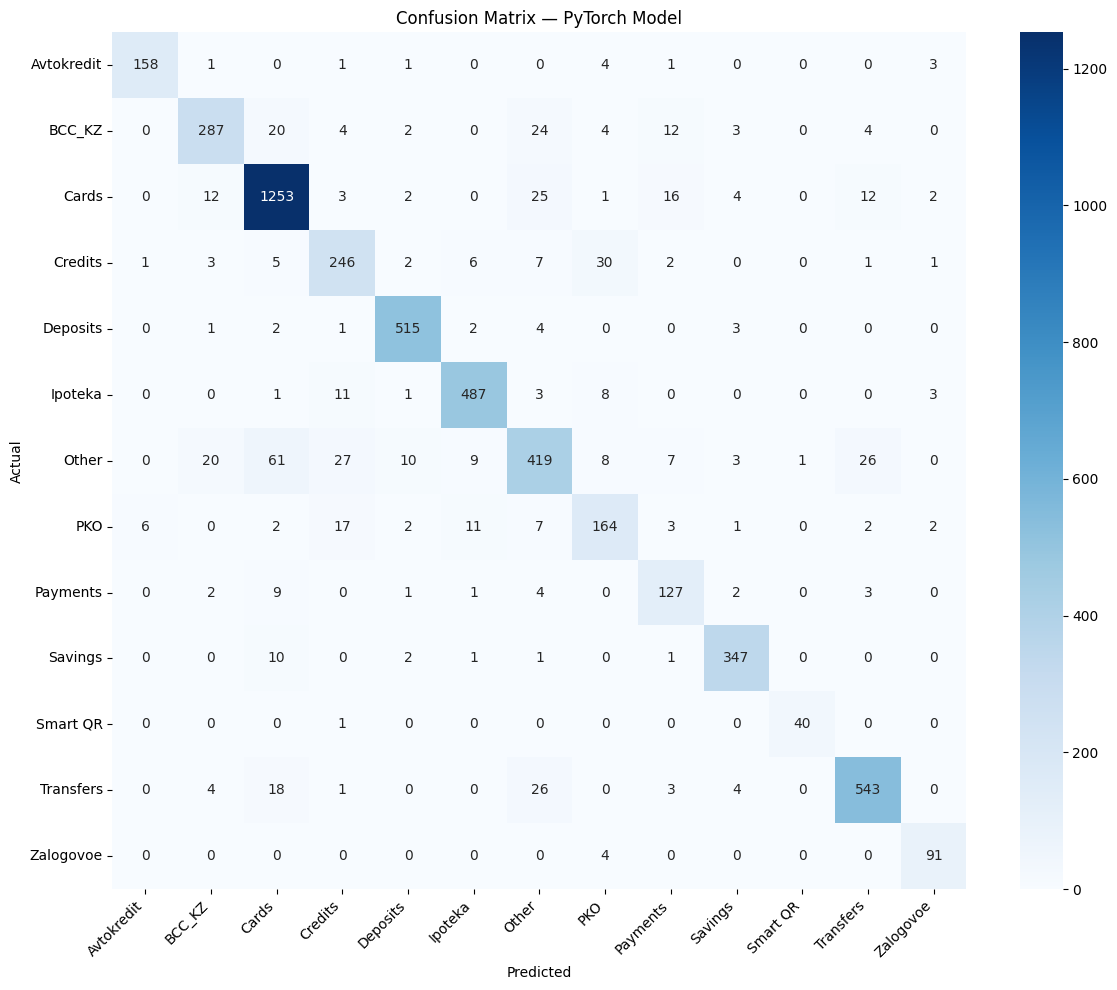

In [47]:
# === Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = cat_encoder.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix — PyTorch Model")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
# === Константы ===
BASE_SAVE_DIR = "models/category_model"  # Здесь будет tokenizer, onnx, encoder
MAX_LEN = 128

# === Сохраняем токенизатор один раз ===
os.makedirs(BASE_SAVE_DIR, exist_ok=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer_save_dir = os.path.join(BASE_SAVE_DIR, "tokenizer")
if not os.path.exists(tokenizer_save_dir):
    tokenizer.save_pretrained(tokenizer_save_dir)
    print(f"✅ Токенизатор сохранён в {tokenizer_save_dir}")

✅ Токенизатор сохранён в models/category_model/tokenizer


In [36]:
# === Сохраняем LabelEncoder ===
joblib.dump(cat_encoder, os.path.join(BASE_SAVE_DIR, "label_encoder.pkl"))
print(f"✅ LabelEncoder сохранён.")

✅ LabelEncoder сохранён.


In [37]:
# === Перевод модели на CPU и экспорт в ONNX ===
model.eval().to("cpu")
dummy_inputs = tokenizer(
    "пример текста",
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=MAX_LEN
)

onnx_path = os.path.join(BASE_SAVE_DIR, "model.onnx")

torch.onnx.export(
    model,
    (dummy_inputs["input_ids"], dummy_inputs["attention_mask"]),
    onnx_path,
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},
        "attention_mask": {0: "batch_size", 1: "sequence_length"},
        "logits": {0: "batch_size"}
    },
    opset_version=17
)
print(f"✅ ONNX-модель экспортирована в {onnx_path}")

✅ ONNX-модель экспортирована в models/category_model/model.onnx
